# Chapter 13: Nonlinear Classification Models

In [16]:
import shutup; shutup.please()
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os, warnings
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<Figure size 640x480 with 0 Axes>

In [73]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')

## 0. Read Data

In [3]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training = pd.read_csv('./grantdata_training.csv')
testing = pd.read_csv('./grantdata_testing.csv')
year2008Data = pd.read_csv('./grantdata_year2008Data.csv')

# Full set and Reduced set of features
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()

In [4]:
print(f"Full set has {len(fullSet)} features, and reduced set has {len(reducedSet)} features.") #1069,  255 changed Day to yDay
print(training.info())
print(testing.info())
print(year2008Data.info())

Full set has 1069 features, and reduced set has 255 features.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 30.0+ MB
None


In [5]:
trainData = training[~training.index.isin(year2008Data.index)]
validData = training[training.index.isin(year2008Data.index)]
fillNAcols = ['CI.PhD','DR.PhD','ECI.PhD','HV.PhD','PS.PhD','SR.PhD','EA.PhD','SCI.PhD','UNK.PhD']
trainData[fillNAcols] = trainData[fillNAcols].fillna(0)
validData[fillNAcols] = validData[fillNAcols].fillna(0)

trainData['yDay2'] = trainData['yDay']**2
validData['yDay2'] = validData['yDay']**2

In [6]:
trainX0 = trainData.drop(columns = ['Class'])
trainy = trainData['Class'].apply(lambda x : 1 if x =='successful' else 0)
validX0 = validData.drop(columns = ['Class'])
validy = validData['Class'].apply(lambda x : 1 if x =='successful' else 0)

In [7]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, get_scorer_names
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

In [8]:
cv = ShuffleSplit(n_splits = 4, test_size = 0.25, random_state=3)

def modelPerf(model, X, y):
    nl = '\n'
    y_true = y
    y_pred = model.predict(X)
    print(f"Terms: 1 for positive case, and 0 for negative case. \
    {nl}  P - the number of real positive cases in the data \
    {nl}  TP - a test result that correctly indicates the presence of a condition \
    {nl}  FP - a test result which wrongly indicates that a condition is present \
    {nl}  N - the number of real negative cases in the data \
    {nl}  TN - a test result that correctly indicates the absence of a condition \
    {nl}  FN - a test result which wrongly indicates that a condition is absent \
    {nl}  Precision, positive predicitive value(PPV) - TP/(TP+FP) \
    {nl}  Reacll, sensitivity, true positive rate(TPR) - TP/P \
    {nl}  Specificity, selectivity, true negative rate(TNR) - TN/N \
    {nl}  Accuracy - (TP+TN)/(P+N)")
    print(f"The confusion matrix \
    {nl}  TN | FP \
    {nl}  FN | TP")
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

## 1. Nonlinear Discriminant Analysis

In [9]:
trainX = trainX0[reducedSet]
validX = validX0[reducedSet]

In [10]:
sc = StandardScaler()
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [11]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(reg_param =0.5)

In [17]:
qda_param = {'reg_param':np.linspace(0,1,52)}
qdaGS = GridSearchCV(qda, qda_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
qdaGS.fit(trainX_scaled, trainy)
qdaModel = qdaGS.best_estimator_

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.

In [13]:
qdaModel

QuadraticDiscriminantAnalysis(reg_param=1.0)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.8015152 0.7671114 0.7839360      3448
           1  0.7147425 0.7544057 0.7340387      2667

    accuracy                      0.7615699    

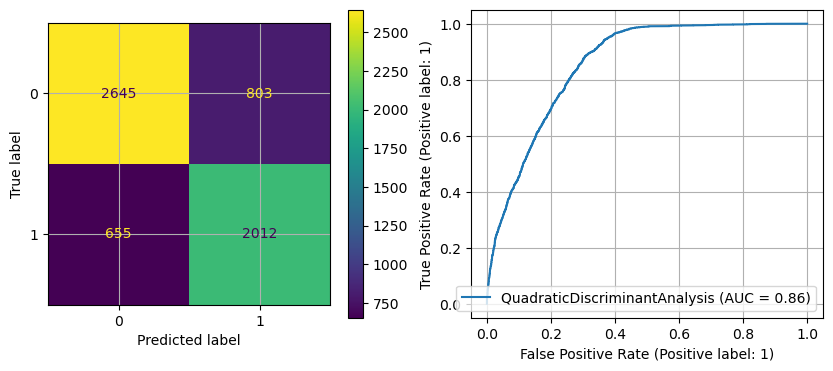

In [14]:
modelPerf(qdaModel,trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.5984321 0.7292994 0.6574163       942
           1  0.7249191 0.5931156 0.6524272      1133

    accuracy                      0.6549398    

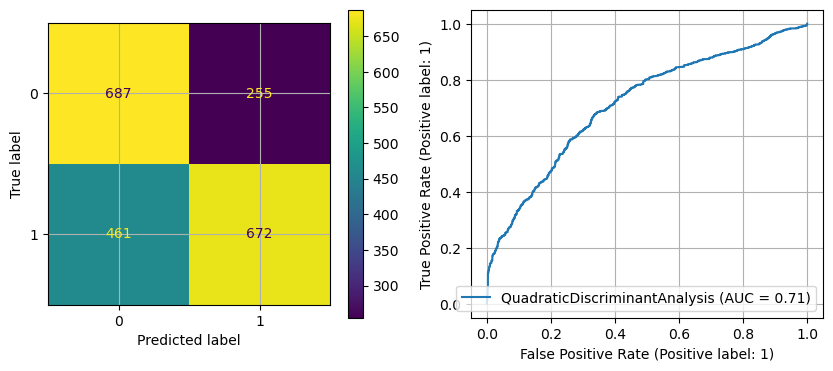

In [15]:
modelPerf(qdaModel,validX_scaled, validy)

## 2. Neural Networks

### 2.1 Neural Network with 2 predictors

In [278]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [235]:
def plot2ClassData(trainX, trainy):
    if type(trainX) != 'pandas.core.frame.DataFrame':
        trainX = pd.DataFrame(trainX)
    if type(trainy) != 'pandas.core.frame.DataFrame':
        trainy = pd.DataFrame(trainy)
        
    colors = ['r', 'b']
    markers = ['o', 's']
    c = ['Class1', 'Class2']
    fig, ax  = plt.subplots()
    for k, m in enumerate(colors):
        i = np.where(trainy.iloc[:,0] == c[k])[0]
        if k == 0:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
        else:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

    ax.set_title('Original Data')
    ax.set_xlabel('Predictor A')
    ax.set_ylabel('Predictor B')
    ax.legend(loc='upper center', ncol=2)
    ax.grid(False)
    return ax

def plotDecisionBoundary(clf, trainX, trainy):
    if type(trainX) != 'pandas.core.frame.DataFrame':
        trainX = pd.DataFrame(trainX)
    if type(trainy) != 'pandas.core.frame.DataFrame':
        trainy = pd.DataFrame(trainy)
        
    colors = ['r', 'b']
    markers = ['o', 's']
    c = ['Class1', 'Class2']
    fig, ax  = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
    clf, trainX, response_method="predict", alpha=0.5,ax =ax, grid_resolution=500)
    for k, m in enumerate(colors):
        i = np.where(trainy.iloc[:,0] == c[k])[0]
        if k == 0:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
        else:
            ax.scatter(trainX.iloc[i, 0], trainX.iloc[i, 1], 
                        c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

    ax.set_xlabel('Predictor A')
    ax.set_ylabel('Predictor B')
    ax.legend(loc='upper center', ncol=2)
    ax.grid(False)
    return ax

In [107]:
rdata = pyreadr.read_r("/Users/chenxu/Documents/dataset/AppliedPredictiveModeling/data/twoClassData.RData")

trainX = pd.DataFrame(rdata['predictors'])
trainy = pd.DataFrame(rdata['classes'])
trainX_scaled = pd.DataFrame(sc.fit_transform(trainX))

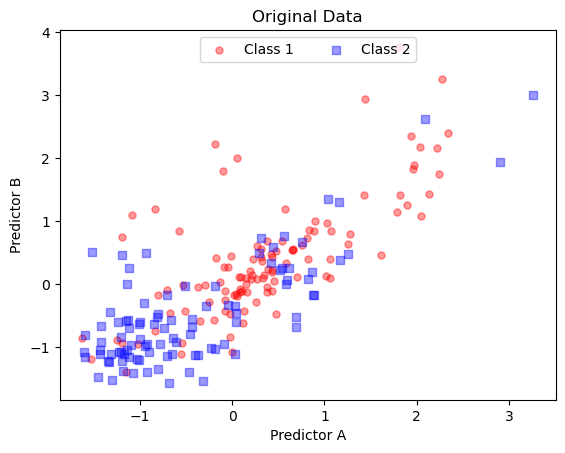

In [239]:
_ = plot2ClassData(trainX_scaled, trainy)

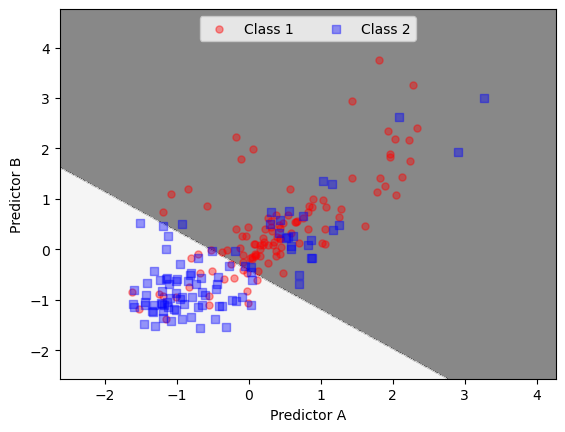

In [267]:
weight_decay = 0.1
clf1 = MLPClassifier(solver ='lbfgs',alpha=weight_decay*208,hidden_layer_sizes=(3,), random_state=20)
clf1.fit(trainX_scaled,trainy)
_ = plotDecisionBoundary(clf1,trainX_scaled, trainy)

In [275]:
n_models = 5
MLPList = []
np.random.seed(seed = 43)
for s in np.random.randint(100,size=n_models):
    MLPList.append(('mlp'+str(len(MLPList)),MLPClassifier(solver ='lbfgs',alpha=weight_decay*208,hidden_layer_sizes=(3,), random_state=s)))

avNN = VotingClassifier(MLPList, voting = 'soft')
avNN.fit(trainX_scaled, trainy)

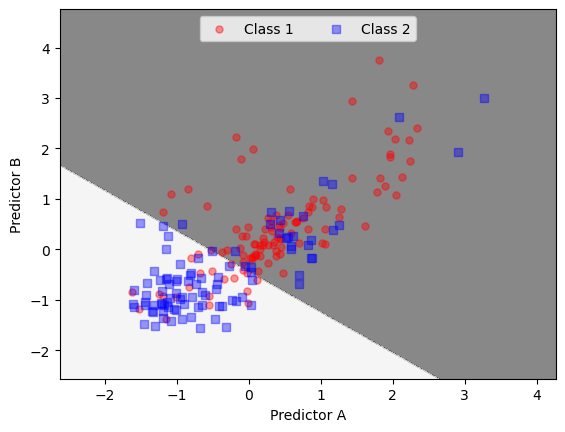

In [276]:
_ = plotDecisionBoundary(avNN,trainX_scaled, trainy)